# Bayes by Backprop

Sometimes it is important to learn parameter (and hence inference) uncertainty in a model. In the paper, [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424), the author's show how to get, well, the uncertainty in the weights.

## Linear Regression with Uncertainty

To demonstrate the basic idea of trying to learn parameter uncertainty, I will do a simple regression problem. Consider the function,

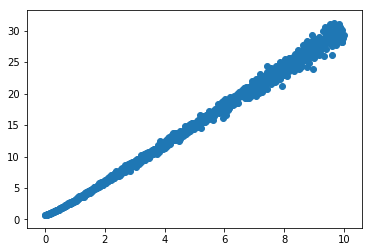

In [70]:
import mxnet as mx
from mxnet import nd, autograd
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return nd.log(1.0 + nd.exp(x))

x = nd.arange(0, 10, 0.01)
y_clean = f(3 * x)
y = f((3 + 0.1*nd.random_normal(shape=x.shape)) * x)

plt.plot(x.asnumpy(), y_clean.asnumpy())
plt.scatter(x.asnumpy(), y.asnumpy())
plt.show()

If we simply learn the parameters, then we don't capture the noise level in our finished model. We can instead train with a noise term in the model and capture the standard deviation for the parameters as well! This is done by claiming the weights to be,

\begin{align}
w &= \mu + \sigma \circ \epsilon \\
\epsilon &\sim \mathcal{N}(0, \mathbb{1})
\end{align}

where $ \circ $ is element-wise operation. This allows us to train with the behavior of randomness in the weights. The magnitude of the randomness is parameterized by $ \sigma $ so as we train, we learn a level of uncertainty in our model. If you want more rigour than "randomness", I invite you to read the paper. It is very accessible.

In the paper, they use a trick to parameterize the std like $ \sigma = \log \big( 1 + \exp(\rho) \big) $ so it is always positive. Using this trick, lets train a model.

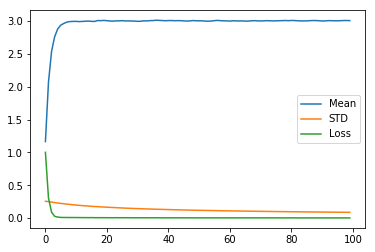

In [73]:
batch_size = 100
train_data = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(x, y),
                                      batch_size=batch_size, shuffle=True)

ctx = mx.cpu()
learning_rate = 0.001

w = nd.random_normal(shape=(1,))
w.attach_grad()
rho = nd.random_normal(shape=(1,))
rho.attach_grad()

means, stds, losses = [], [], []
for epoch in range(100):
    losses.append([])
    for data, label in train_data:
        xx = data.as_in_context(ctx)
        yy = label.as_in_context(ctx).reshape((-1, 1))
        eps = nd.random_normal(shape=yy.shape)
        with autograd.record():
            output = f((w + eps * nd.log(1.0 + nd.exp(rho))) * xx)
            loss = nd.mean((output - yy)**2)
        loss.backward()
        w[:] = w - learning_rate*w.grad
        rho[:] = rho - learning_rate*rho.grad
        losses[-1].append(loss.asnumpy())
    means.append(w.asnumpy())
    stds.append(nd.log(1.0 + nd.exp(rho)).asnumpy())
    losses[-1] = np.mean(losses[-1])

plt.plot(means)
plt.plot(stds)
plt.plot(np.array(losses)/losses[0])
plt.legend(['Mean', 'STD', 'Loss'])
plt.show()

The resultant parameters and predicted output are,

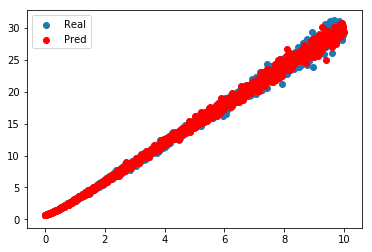

In [74]:
y_pred = f((w + nd.random_normal(shape=x.shape) * nd.log(1.0 + nd.exp(rho))) * x)
plt.scatter(x.asnumpy(), y.asnumpy())
plt.scatter(x.asnumpy(), y_pred.asnumpy(), c='r')
plt.legend(['Real', 'Pred'])
plt.show()

Now, there is a little quirk I should own up to instead of hiding. If you raise the number of epochs, the std keeps dropping. Eventually, it doesn't give you the std that the data was generated with. So ... I guess it should be noted that this method doesn't give you the std of the noise the data was subject to, just the uncertainty of the model.

This isn't particularly bad. In fact, this could actually be useful because we can see the uncertainty in the model decrease with epochs.

# Uncertain MLP Layer

MxNet offers the ability to define new types of layers.

In [1]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from mxnet import gluon

Create a new layer that includes some noise

In [43]:
class NoiseDense(gluon.nn.Dense):
    def __init__(self, *args, weight_std_initializer=None, bias_std_initializer='zeros', **kwargs):
        super(NoiseDense, self).__init__(*args, **kwargs)
        self.weight_std = self.params.get('weight_std', shape=self.weight.shape,
                                          init=weight_std_initializer,
                                          allow_deferred_init=True)
        if self.bias is None:
            self.bias_std = self.params.get('bias_std', shape=self.bias.shape,
                                            init=bias_std_initializer,
                                            allow_deferred_init=True)
    
    def hybrid_forward(self, F, x, weight, weight_std, bias=None, bias_std=None):
        act = F.FullyConnected(x, weight + nd.random_normal(shape=self.weight_std.shape) * self.weight_std,
                               None if bias is None 
                               else bias + nd.random_normal(shape=self.bias_std.shape)*self.bias_std,
                               no_bias=bias is None, num_hidden=self._units,
                               flatten=self._flatten, name='fwd')
        if self.act is not None:
            act = self.act(act)
        return act

In [47]:
ctx = mx.cpu()

mnist = mx.test_utils.get_mnist()
batch_size = 64
num_inputs = 784
num_outputs = 10
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

num_hidden = 256
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(NoiseDense(num_hidden, activation="relu"))
    net.add(NoiseDense(num_hidden, activation="relu"))
    net.add(NoiseDense(num_outputs))
    
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

epochs = 10
for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            loss.backward()
        trainer.step(data.shape[0])

TypeError: type <class 'mxnet.gluon.parameter.Parameter'> not supported